Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.7.9


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [3]:
import urllib.request
url = 'https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6'
filename = 'sent_lexicon'
urllib.request.urlretrieve(url, filename)

('sent_lexicon', <http.client.HTTPMessage at 0x2a176b57048>)

In [4]:
url = 'https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760'
filename = 'reviews.json'
urllib.request.urlretrieve(url, filename)

('reviews.json', <http.client.HTTPMessage at 0x2a176b57b88>)

In [5]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [6]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (2+1pts)



A traditional approach to automatically classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative) or a sentiment score (e.g., a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005). The path of the loaded lexicon is `"sent_lexicon"`.

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon.


Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon.

In [7]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 10:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abash pos1=verb stemmed1=y priorpolarity=negative
type=weaksubj len=1 word1=abate pos1=verb stemmed1=y priorpolarity=negative
type=weaksubj len=1 word1=abdicate pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=aberration pos1=adj stemmed1=n priorpolarity=negative
type=strongsubj len=1 word1=aberration pos1=noun stemmed1=n priorpolarity=negative
type=strongsubj len=1 word1=abhor pos1=anypos stemmed1=y priorpolarity=negative


Given such a sentiment lexicon, there are ways to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [8]:

def content_to_sentence(content):
    '''
        Creates a sentence (list) of the content of a review
        content: [(word: string, POS: string)]
        returns: [word: string]
    '''
    whole_review = []
    for sentence in content:
        whole_review += [word.lower() for word in np.array(sentence)[:, 0]]
    
    return whole_review

def create_dataset(reviews):
    '''
        Creates the dataset given the reviews
        Splits it up in sentences and the target class:
        returns: sentences: [[word: string]], [int] 
    '''
    targets = []
    sentences = []
    
    ### Loop over the reviews, get the target, and make 1 sentence of the content. 
    for review in reviews:
        targets.append(int( review['sentiment'] == 'POS'))
        
        whole_review = content_to_sentence(review['content'])
        sentences.append(whole_review)
    return sentences, targets

sentences, targets = create_dataset(reviews)


In [9]:
### Load the lexixon in a default dict
from collections import defaultdict

## The possible sentiments
sentiments = {
    'positive': 1,
    'negative': -1,
    'both': 0,
    'neutral': 0
}

def get_slex(ref="sent_lexicon"):
    '''
    Creates the sentiment lexicon
    ref: reference of the file 
    returns: Defaultdictionary{word:  sentiment score} 
    
    '''
    slex = defaultdict(float)
    
    ## indexes
    key_index = 2
    key_strip = "word1="
    value_index = 5
    value_strip = "priorpolarity="
    
    magnitude_index = 0
    magnitude_strip = "type="
    
    magnitude_choices = defaultdict(float, {
        "weaksubj": 1.0,
        "strongsubj": 2.0
    })
    
    with open("sent_lexicon", mode="r", encoding="utf-8") as f:
        
        line_cnt = 0
        for line in f:
            line_cnt += 1
            line_arr = line.split()
            magnitude = magnitude_choices[ line_arr[magnitude_index].replace(magnitude_strip, "")]
            sentiment = sentiments[line_arr[value_index].replace(value_strip, "")]
            slex[line_arr[key_index].replace(key_strip, "")] =  magnitude * sentiment
    return slex


    
slex = get_slex()


class BinarySentimentClassifier:
    '''
        The binary classifier, that uses a threshold and the binary score to classify a review
        
    '''
    def __init__(self, slex, threshold):
        self.slex = slex
        self.threshold = threshold

    def predict(self, sentences):
        return [int( self.binary_sentiment(sentence) > self.threshold) for sentence in sentences ]
    
    def binary_sentiment(self, sentence):
        '''
        sentence: sentence to calculate the sentiment from
        returns the binary sentiment score of a sentence given the sentiment lexicon
        '''
        return np.sum([ np.sign( self.slex[word])   for word in sentence])



# Create the classifier:
bin_sent_model = BinarySentimentClassifier(slex, 8)

predictions = bin_sent_model.predict(sentences)


In [10]:

def calculate_results(predictions, targets):
    '''
        prediction: predictions of a model
        targets: the ground truth
        returns an array containing a 0 if the prediction is incorrect and 1 otherwise
    '''
    return np.array(predictions) == np.array(targets)

def calculate_accuracy(predictions, targets):
    '''
        Calculates the accuracy of the predictions
    '''
    return np.sum(calculate_results(predictions, targets)) / len(targets)

In [11]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = calculate_results(predictions, targets)
token_accuracy = calculate_accuracy(predictions, targets)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [12]:
### To calculate the bias we calculate the avarage sentiment of each review. 
### Reviews that have a higher sentiment then the avarage will get a positive label, and negative label otherwise
avg = 0
total = 0
for sentence in sentences:
    total += np.sum([ slex[word]   for word in sentence])
avg = total / len(sentences)
print(avg)

10.8195


In [13]:

class MagnitudeClassifier:
    
    def __init__(self, slex, threshold):
        self.slex = slex
        self.threshold = threshold

    def predict(self, sentences):
        return [int( self.binary_sentiment(sentence) > self.threshold) for sentence in sentences ]
    
    def binary_sentiment(self, sentence):
        '''
        sentence: sentence to calculate the sentiment from
        returns the binary sentiment score of a sentence given the sentiment lexicon
        '''

        return np.sum([ self.slex[word]   for word in sentence])

magnitude_model = MagnitudeClassifier(slex, avg)

predictions = magnitude_model.predict(sentences)


In [14]:
magnitude_results = calculate_results(predictions, targets)
magnitude_accuracy = calculate_accuracy(predictions, targets)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


#### Make a barplot of the two results.

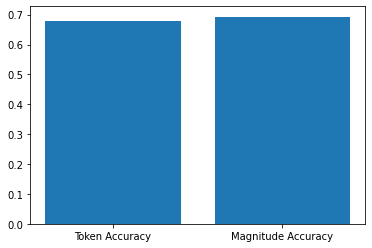

In [15]:
plt.bar(['Token Accuracy', 'Magnitude Accuracy'], [token_accuracy, magnitude_accuracy])
plt.show()

## (Q1.3 Optional) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

Take the case that we have a review of 7 words, in that case we would never get that at least 7 words in the review are positive. 
Therefore small reviews have a smaller chance of crossing the threshold of having at least 8 more positive words than negative.

Normalizing with respect to the length of a review would countaract this problem. 





In [16]:
## calculate the average percentage of the difference in positive and negative words
avg = 0
total = 0

for sentence in sentences:
    pos_count = 0
    neg_count  = 0
    for word in sentence:
        s = np.sign(slex[word]) 

        if  s < 0:
            neg_count += 1
        if s > 0:
            pos_count += 1
    total += ((pos_count - neg_count) / len(sentence))


avg = total/len(sentences) 
print(avg)



0.009082534363548262


In [17]:
class BinarySentimentPercClassifier:
    
    def __init__(self, slex, threshold):
        self.slex = slex
        self.threshold = threshold

    def predict(self, sentences):
        return [int( self.binary_sentiment(sentence) > ( self.threshold * len(sentence) )) for sentence in sentences ]
    
    def binary_sentiment(self, sentence):
        '''
        sentence: sentence to calculate the sentiment from
        returns the binary sentiment score of a sentence given the sentiment lexicon
        '''
        return np.sum([ np.sign(self.slex[word])   for word in sentence])
                    
perc_model = BinarySentimentPercClassifier(slex, avg)

predictions = perc_model.predict(sentences)
perc_results = predictions
perc_accuracy = calculate_accuracy(predictions, targets)
print("Accuracy: %0.2f" % perc_accuracy)

Accuracy: 0.66


Unfortunatly, as you can see, using a percentual threshold does not create a better classifier. 

# Significance testing

Does using the magnitude improve the results? Oftentimes, answering such questions by simply comparing accuracy
scores is not enough. When dealing with natural language and human ratings, it is safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are due to mere chance.

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 

In this experiment, $q = 0.5$, so the formula simplifies to:
$$2\times 0.5^N\, \sum\limits_{i=0}^{k} \binom{N}{i}$$


We use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.


In [18]:
from decimal import Decimal
from scipy.special import comb


def sign_test(results_1, results_2):
  """test for significance"""
  ties, plus, minus = 0, 0, 0

  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]==0: 
      plus += 1
    elif results_2[i]==0: 
      minus += 1

  n = (2 * math.ceil(ties/2.0)) + plus + minus
  k = math.ceil(ties/2.0) + min(plus,minus)

  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
      summation += (Decimal(comb(n,i,exact=True)))

  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(0.5)**Decimal(n))
  
  print("the difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation

p_value = sign_test(token_results, magnitude_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.5024515744752503461039016873


### Using the Sign test

**From now on, report all differences between systems, as well as between system configurations, using the
sign test.**
    
You should report statistical test
results in an appropriate form. If there are several different methods
(i.e., systems) to compare, the Sign test can only be applied to pairs of them
at a time. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


# Naive Bayes (10pt)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q3.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**. 

In case 2, you could also set $P(c|\bar{f}) = 0$ for the class $c$ within which $f_i \in \bar{f}$ was not seen. One way to implement this in log space is to set $P(c|\bar{f}) = -\infty$. What would be the problem instead with skipping words only for one class in case 2? 

#### answer 
If we do not skip both classes, a review with this word only seen in one class will always get probability 0 of belonging to the other class. This happens regardless of all the other words in the review. So we could have a review with all positive words and one word never seen in the positive class, this review would now get a probability 0 of being positive and (as long as all the other words are at least seen once in the negative class) will get a positive probability of being negative. 
Thats not very sensible. If we have multiple of such words, we could even have reviews that have probability 0 for both classes.



#### (Q3.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [19]:
def create_dataset_split(reviews, cv_train, cv_test, remove_pos=[], remove_neg=[]):
    '''
        Creates a splitted dataset based on the reviews. 
    '''
    
    #### Split the reviews in the train/test sets
    train_reviews = []
    test_reviews = []
    
    for review in reviews:
        ### As long as we do not want to remove them we can add them:
        if not ((review['cv'] in remove_pos and review['sentiment'] == "POS" )
                 or (review['cv'] in remove_neg) and review['sentiment'] != "POS"):
            if review['cv'] in cv_train:
                train_reviews.append(review)
            if review['cv'] in cv_test:
                test_reviews.append(review)
    ### Create and return the datasets
    train_sentences, train_targets = create_dataset(train_reviews)
    test_sentences, test_targets = create_dataset(test_reviews)
    return train_sentences, train_targets, test_sentences, test_targets




In [20]:
from tqdm import tqdm
def create_voc(sentences):
    '''
        Creates a vocubulair of the sentences
        
        returns list of words.
    '''
    voc = list(set([word for sentence in sentences for word in sentence]))

    return voc
    

class NaiveBayesClassifier:
    
    def __init__(self, k=0):
        self.log_likelihood = defaultdict(float)
        self.log_prior = defaultdict(float)
        self.voc = None
        self.counts = defaultdict(float)
        self.k = k
    
    def fit(self, sentences, targets):
        '''
            Fits the naive bayes classifier, given the sentences and the targets
        '''
        
        ### Compute the relevant statistics.
        n_doc = len(sentences)
        n_pos = np.sum(targets)
        n_neg = n_doc - n_pos
        
        self.log_prior = {
            0: np.log(n_neg/n_doc),
            1: np.log(n_pos/n_doc)
        } 
        

        ### Create the vocubulair.
        self.voc = create_voc(sentences)
        
        ### Split in positive and negative sentences. 
        pos_idx = np.array(targets) == 1
        doc = {
            0: np.array(sentences, dtype=object)[~pos_idx],
            1:  np.array(sentences, dtype=object)[pos_idx]
        }
        

        ### Count the words for each class. 
        for c, sentences in doc.items():
            for sentence in sentences:
                for w in sentence:
                    self.counts[(w,c)] += 1
        
        ### Keep track of the total counts, add the smoothing constant. 
        total_counts = {
            0: np.sum([self.counts[(w,0)] + self.k if self.seen_by_both(w) else 0 for w in self.voc]),
            1: np.sum([self.counts[(w,1)] + self.k if self.seen_by_both(w) else 0 for w in self.voc])
        }

        ### Calculate the log likelihood of each word class combination, add smoothing if neccasery. 
        for c in [0,1]:
            if total_counts[c] != 0:
                for w in self.voc:
                    ### We only count words that have been seen by both the classes
                    if self.seen_by_both(w):
                        self.log_likelihood[(w, c)] = np.log( (self.counts[(w,c)] + self.k )/ total_counts[c])
                        
    def seen_by_both(self, w):
        '''
        checks if a word is seen by both:
        '''
        return self.counts[(w,0)] + self.k > 0 and self.counts[(w,1)] + self.k > 0
    
    def predict(self, sentences):
        '''
            Predict the label of the given sentences
        '''
        result = []
        for sentence in tqdm(sentences):
            result.append(self.predict_1(sentence))
        return result
    
    def predict_1(self, sentence):
        '''
            Predicts the label of one sentence
        '''
        
        sum_c = [self.log_prior[0], self.log_prior[1]]
        for c in [0,1]:
            for word in sentence:
                    ### Note that we implicitally use that words that did not appear do not count, by using a default dict
                    sum_c[c] += self.log_likelihood[(word, c)]
        return np.argmax(sum_c)

    def reset_params(self):
        '''
        Resets the parameters, such that we can do another round of trainig.
        '''
        self.log_likelihood = defaultdict(float)
        self.log_prior = defaultdict(float)
        self.voc = None
        self.counts = defaultdict(float)     
    
train_sentences, train_targets, test_sentences, test_targets = create_dataset_split(reviews, [i for i in range(0,900)], [i for i in range(900,1000)])
naive_bayes_model = NaiveBayesClassifier()
naive_bayes_model.fit(train_sentences, train_targets)

In [21]:
predictions = naive_bayes_model.predict(test_sentences)

naive_bayes_results = calculate_results(predictions, test_targets)
naive_bayes_accuracy = calculate_accuracy(predictions, test_targets)
print("Accuracy: %0.3f" % naive_bayes_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2000.05it/s]

Accuracy: 0.835


#### (Q3.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

No, accuracy would no longer be a good measure. If 90% of the data is positive, we would get a 90% accuracy with a model that always outputs positive. However, this is clearly not a good model. We should use a different metric for such cases.

In our case, we would expect the log priors to be skewed towards positive data as this is now 90% of the data. This should result in more cases being classified at positive and thus in a higher accuracy, as our test data is mostly positive.

In [22]:
train_sentences, train_targets, test_sentences, test_targets = create_dataset_split(reviews, [i for i in range(0,900)], [i for i in range(900,1000)], [], [i for i in range(90, 900)] 
                                                                                    + [i for i in range(910, 1000)])

skewed_naive_bayes = NaiveBayesClassifier()
skewed_naive_bayes.fit(train_sentences, train_targets)
predictions = skewed_naive_bayes.predict(test_sentences)
naive_bayes_all_neg_results = calculate_results(predictions , test_targets)

naive_bayes_all_neg_accuracy = calculate_accuracy(predictions, test_targets)
print("Accuracy: %0.2f" % naive_bayes_all_neg_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 2055.77it/s]

Accuracy: 0.89


As we can see the accuracy becomes close to 0.9, which is what we expected.

## Smoothing (1.5pts)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [23]:
train_sentences, train_targets, test_sentences, test_targets = create_dataset_split(reviews, [i for i in range(0,900)], [i for i in range(900,1000)])
smooth_naive_bayes_model = NaiveBayesClassifier(1)
smooth_naive_bayes_model.fit(train_sentences, train_targets)

In [24]:
predictions = smooth_naive_bayes_model.predict(test_sentences)

smoothed_naive_bayes_results = calculate_results(predictions, test_targets)
smoothed_naive_bayes_accuracy = calculate_accuracy(predictions, test_targets)
print("Accuracy: %0.3f" % smoothed_naive_bayes_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1923.54it/s]

Accuracy: 0.825


#### (Q3.5) Is the difference between non smoothed (Q3.2) and smoothed (Q3.4) statistically significant? (0.5pt)

In [25]:

p_value = sign_test(smoothed_naive_bayes_results, naive_bayes_results)
print("p_value =", p_value)


the difference is not significant
p_value = 0.9436515209907435777527547357


As you can see the difference between non smoothed and smoothed variant is not statistically significant. So there is not a statistically significant impact on performance. 

This is probably due the fact that our naive bayes skips unseen words, with has a similar effect as smoothing. 

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q3.6) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [26]:
def create_folds(data, n_folds):
    '''
    Creates folds using round-robin splitting
    '''
    review_folds = [[] for i in range(n_folds)]
    label_folds = [[] for i in range(n_folds)]

    for review in data:
        i = review['cv'] % n_folds
        whole_review = content_to_sentence( review['content'])
        review_folds[i].append(whole_review)
        label_folds[i].append(int( review['sentiment'] == 'POS'))
    return review_folds, label_folds

        
review_folds, label_folds = create_folds(reviews, 10)


In [27]:
def train_on_fold(model, x_folds, y_folds, held_out_index):
    '''
        Train the given model on the folds. Use held_out_index to check what the held out fold is.
    '''
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in range(len(x_folds)):
        if i != held_out_index:
            train_x += x_folds[i]
            train_y += y_folds[i]
        else:
            test_x += x_folds[i]
            test_y += y_folds[i]

    
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    results = calculate_results(predictions, test_y)
    accuracy  = calculate_accuracy(predictions, test_y)
    return accuracy, predictions, results

def train_on_folds(create_model, x_folds, y_folds):
    '''
        Trains a model on the given folds.
        Create_model: a function that returns a model that we want to train
        x_folds: list of folds with the input features
        y_folds: list of folds with the target class. 
    '''
    models = [create_model() for i in range(len(x_folds))]
    accuracies = []
    predictions = []
    results = []
    
    ### Loop over the folds. 
    for i, fold in enumerate(x_folds):
        model = models[i]
        accuracy, prediction, result = train_on_fold(model, x_folds, y_folds, i)
        
        accuracies.append(accuracy)
        predictions.append(predictions)
        results.append(result)
    return models, accuracies, predictions, results


In [28]:

### Function to create a naive bayes model with k=1
create_naive_bayes_model = lambda: NaiveBayesClassifier(1)
naive_bayes_models, naive_bayes_accuracies, naive_bayes_predictions, naive_bayes_results = train_on_folds(create_naive_bayes_model, review_folds, label_folds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2027.68it/s]


In [29]:
print("Accuracies: ", naive_bayes_accuracies)
print("mean: ", np.mean(naive_bayes_accuracies))


Accuracies:  [0.79, 0.835, 0.805, 0.825, 0.78, 0.845, 0.83, 0.775, 0.83, 0.84]
mean:  0.8154999999999999


#### (Q3.7) Write code to calculate and report the variance of the 10 accuracy scores, in addition to the final performance. You must not use a library, such as numpy. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [30]:
def compute_mean(values):
    '''
        Computes the mean of the given values
    '''
    total = 0
    for val in values:
        total += val
    return total/len(values)

def compute_std(values):
    '''
        Computes the standard deviation of the given values
    '''
    mean = compute_mean(values)
    tmp_sum = 0
    for val in values:
        tmp_sum += (val- mean)**2
    return math.sqrt(1/len(values) * tmp_sum )


print(naive_bayes_accuracies)
print(compute_mean(naive_bayes_accuracies))
print(compute_std(naive_bayes_accuracies))


[0.79, 0.835, 0.805, 0.825, 0.78, 0.845, 0.83, 0.775, 0.83, 0.84]
0.8155000000000001
0.024540782383616025


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.

You should also perform cross-validation. Concatenate the predictions from all folds to compute the significance.

In [31]:
from nltk.stem import *

def stem_sentences(sentences):
    
    '''
        Applies porter stemmer to all words in the sentences using a look-up table
    '''
    stemmer = PorterStemmer()
    stem_dict = {}
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence):
            if word not in stem_dict:
                stem_dict[word] = stemmer.stem(word)
            sentences[i][j] = stem_dict[word]
    return sentences



### Preprocess the sentences
stemmed_x_folds = [stem_sentences(x) for x in review_folds]



In [32]:
stemmed_models, stemmed_accuracies, stemmed_predictions, stemmed_results  = train_on_folds(create_naive_bayes_model, stemmed_x_folds, label_folds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2105.30it/s]


In [33]:
print(stemmed_accuracies)
print(compute_mean(stemmed_accuracies))
print(compute_std(stemmed_accuracies))

[0.78, 0.84, 0.805, 0.84, 0.775, 0.84, 0.82, 0.775, 0.83, 0.83]
0.8135
0.026177280225416825


#### (Q3.9): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (1pt)


In [34]:
## Concatonate the results in one array
concat_stemmed_results = np.array(stemmed_results).reshape(-1)
concat_naive_bayes_results = np.array(naive_bayes_results).reshape(-1)
### 
p_value = sign_test(concat_stemmed_results, concat_naive_bayes_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.9465186089423488346539016590


#### (Q3.10) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [35]:
train_sentences, train_targets, test_sentences, test_targets = create_dataset_split(reviews, [i for i in range(0,900)], [i for i in range(900,1000)])

unstemmed_model = NaiveBayesClassifier(k=1)
unstemmed_model.fit(train_sentences, train_targets)
print("Unstemmed features: {}".format(len(unstemmed_model.voc)))

stemmed_model = NaiveBayesClassifier(k=1)
stemmed_train_sentences = stem_sentences(train_sentences)
stemmed_model.fit(stemmed_train_sentences, train_targets)
print("Stemmed features: {}".format(len(stemmed_model.voc)))


Unstemmed features: 45348
Stemmed features: 32404


In [36]:
print("So the number of features has decreased by {}".format(len(unstemmed_model.voc) - len(stemmed_model.voc)))

So the number of features has decreased by 12944


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-gram** features. 






#### (Q3.11) Retrain your classifier from (Q3.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and statistical significances (in comparison to the experiment at (Q3.6) for all 10 folds, and between the new systems). You are allowed to use NLTK to build n-grams from sentences.

In [37]:
from nltk import ngrams


def to_n_grams(sentences, ns=[1,2,3]):
    '''
        Creates n grams from the sentences
        sentences: the sentences to create n_grams from
        ns: list of grams that we want to create
        returns: list containing sentences of ngrams. 
    '''
    
    result = []
    
    for sentence in sentences:
        temp = []
        for n in ns:
            temp += ngrams(sentence, n)
        result.append(temp)
    return result


un_bi_gram_x = [to_n_grams(x, ns=[1,2]) for x in review_folds]


In [38]:
un_bi_models, un_bi_accuracies, un_bi_predictions, un_bi_results  = train_on_folds(create_naive_bayes_model, un_bi_gram_x, label_folds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 595.29it/s]


In [39]:
print("unigram and bigram accuracies: ", un_bi_accuracies)
print("mean: {} and std: {}".format(compute_mean(un_bi_accuracies), compute_std(un_bi_accuracies)))

unigram and bigram accuracies:  [0.79, 0.845, 0.835, 0.87, 0.805, 0.855, 0.845, 0.815, 0.84, 0.83]
mean: 0.833 and std: 0.02271563338320108


In [40]:
## Concatonate the results in one array
concat_un_bi_results = np.array(un_bi_results).reshape(-1)
concat_naive_bayes_results = np.array(naive_bayes_results).reshape(-1)


### 
p_value = sign_test(concat_un_bi_results, concat_naive_bayes_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.4472188836140076235320103833


In [41]:
un_bi_tri_gram_x = [to_n_grams(x, ns=[1,2, 3]) for x in review_folds]
un_bi_tri_models, un_bi_tri_accuracies, un_bi_tri_predictions, un_bi_tri_results  = train_on_folds(create_naive_bayes_model, un_bi_tri_gram_x, label_folds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 299.37it/s]


In [42]:
print("unigram, bigram  and trigram accuracies: ", un_bi_tri_accuracies)
print("mean: {} and std: {}".format(compute_mean(un_bi_tri_accuracies), compute_std(un_bi_tri_accuracies)))

unigram, bigram  and trigram accuracies:  [0.785, 0.825, 0.83, 0.855, 0.815, 0.845, 0.85, 0.83, 0.84, 0.835]
mean: 0.8309999999999998 and std: 0.019078784028338902


In [43]:
## Concatonate the results in one array
concat_un_bi_tri_results = np.array(un_bi_tri_results).reshape(-1)
concat_naive_bayes_results = np.array(naive_bayes_results).reshape(-1)


### 
p_value = sign_test(concat_un_bi_tri_results, concat_naive_bayes_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.5024515744752503461039016873



#### Q3.12: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q3.10)?

Use the held-out training set once again for this.


Theoretically I would expect that the number of features for O(m^n) where m is the number of unigrams and n is the highest ngram that we use. Because when we use n-grams with m words there are m^n possible different n_grams.
A lot of the n_grams do not appear in practice hence we would expect to have, in practice, a lot less feautures.
As you can see from the prints below, a tiny fraction of the actual number of features is shown in the model that uses un, bi and tri-grams.


In [44]:
train_sentences, train_targets, test_sentences, test_targets = create_dataset_split(reviews, [i for i in range(0,900)], [i for i in range(900,1000)])

un_bi_gram_sentences = to_n_grams(train_sentences, [1, 2])
un_bi_tri_gram_sentences = to_n_grams(train_sentences, [1,2, 3])


un_model = NaiveBayesClassifier()
un_model.fit(train_sentences, train_targets)


un_bi_model = NaiveBayesClassifier()
un_bi_model.fit(un_bi_gram_sentences, train_targets)

un_bi_tri_model = NaiveBayesClassifier()
un_bi_tri_model.fit(un_bi_tri_gram_sentences, train_targets)


n_un_gram_features = len(un_model.voc)
n_un_bi_gram_features = len(un_bi_model.voc)
n_un_bi_tri_gram_features = len(un_bi_tri_model.voc)

print("1_gram features: {}".format(n_un_gram_features))
print("expected 1 and 2 gram features: {}".format(n_un_gram_features ** 2))
print("observed 1 and 2 gram features: {}".format(n_un_bi_gram_features))
print("difference {}".format(n_un_gram_features**2 - n_un_bi_gram_features ))

print("expected 1, 2 and 3 gram features: {}".format(n_un_gram_features ** 3))
print("observed 1, 2  and 3 gram features: {}".format(n_un_bi_tri_gram_features))
print("difference {}".format(n_un_gram_features**3 - n_un_bi_tri_gram_features ))

1_gram features: 45348
expected 1 and 2 gram features: 2056441104
observed 1 and 2 gram features: 471032
difference 2055970072
expected 1, 2 and 3 gram features: 93255491184192
observed 1, 2  and 3 gram features: 1416686
difference 93255489767506


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q4.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing from (Q3.6) and report the numbers.
Perform cross-validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [45]:
### This cell contains a lot of code that we will reuse.
from sklearn import svm
from scipy.sparse import csc_matrix
def create_fold_indexes(reviews, n_folds):
    '''
    Creates folds using round-robin splitting. 
    Returns the index of the folds in which each review should be
    '''
    indexes = []

    for (index, review) in enumerate(reviews):
        i = review['cv'] % n_folds
        indexes.append(i)
    return indexes

def create_voc_of_features(X):
    '''
    Creates a vocabulary of the features that we encounter in the features
    :param X: List features for each datapoint
    :return: a vocabulary of the features
    '''
    voc = list(set([feature for features in X for feature in features]))

    return voc


def create_index_mapping(voc):
    '''
    Creates an index representation of the vocabulary
    First item will have index 1, second 2 etc.. Will reserve index 0 for unseen features.
    :param voc: The vocabulary to create index representation
    :return: a defaultdict containing a mapping from word to index
    '''
    one_hot_mapping = defaultdict(float)
    for i in tqdm(range(1, len(voc) + 1)):
        word = voc[i - 1]
        one_hot_mapping[word] = i
    return one_hot_mapping

def prepare_dataset(reviews, feature_function):
    '''
    Prepares the dataset, in which each review get prepared using the feature_function
    :param reviews:
    :param feature_map:
    :return:
    '''
    targets = []
    X = []

    ### Loop over the reviews, get the target, and make 1 sentence of the content.
    for review in reviews:
        targets.append(int(review['sentiment'] == 'POS'))

        whole_review = feature_function(review)
        X.append(whole_review)
    return X, targets

def review_to_sentence(review):
    '''
        Creates a sentence (list) of the content of a review
        content: [(word: string, POS: string)]
        returns: [word: string]
    '''
    whole_review = []
    for sentence in review['content']:
        whole_review += [word.lower() for word in np.array(sentence)[:, 0]]

    return whole_review

def review_to_words_pos(review):
    '''
        Creates a sentence (list) of the content of a review
        content: [(word: string, POS: string)]
        returns: [word: string]
    '''
    result = []
    for sentence in review['content']:
        result += [(word.lower(), pos) for word, pos in np.array(sentence)]

    return result

def review_to_words_pos_filtered(review):
    '''
        Creates a sentence (list) of the content of a review
        content: [(word: string, POS: string)]
        returns: [word: string]
    '''
    to_keep =  [
        'NN',
        'VB',
        'JJ',
        'RB',
    ]
    result = []
    for sentence in review['content']:
        result += [(word.lower(), pos) for word, pos in np.array(sentence) if pos in to_keep]

    return result

def features_to_indexes(features, index_mapping):
    '''
    Maps the features to their index
    :param features:
    :param index_mapping:
    :return:
    '''
    return [index_mapping[feature] for feature in features]


def counter_to_features(counter, n_features):
    '''
    Creates a vector containing the count of each index
    (Remember that each index represents a feature)
    :param counter: a Counter containing indexes and there counts
    :param n_features: the number of features that are used.
    :return: A numpy array containing the count of each feature in the corresponing index.
    '''
    result = np.zeros(n_features)
    for key, val in counter.items():
        result[key] = val
    return result

def create_feature_matrix(X, index_mapping):
    '''
    Create a sparse representation of the features using the given index map
    :param X:
    :param index_mapping:
    :return:
    '''
    result = []
    n_features = len(index_mapping) + 1
    for i in tqdm(range(len(X))):
        result.append(
            counter_to_features(
                Counter(features_to_indexes(X[i], index_mapping)),
                n_features
            )
        )
    return result


def train_on_fold_svm(model, x_folds, y_folds, held_out_index):
    '''
        Train the given model on the folds. Use held_out_index to check what the held out fold is.
    '''
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in range(len(x_folds)):
        if i != held_out_index:
            train_x += x_folds[i]
            train_y += y_folds[i]
        else:
            test_x = x_folds[i]
            test_y += y_folds[i]

    train_x = csc_matrix(train_x)
    test_x = csc_matrix(test_x)

    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    results = calculate_results(predictions, test_y)
    accuracy = calculate_accuracy(predictions, test_y)
    return accuracy, predictions, results


def train_on_folds_svm(create_model, X, Y, fold_indexes):
    '''
        Trains a model on the given folds.
        Create_model: a function that returns a model that we want to train
        x_folds: list of folds with the input features
        y_folds: list of folds with the target class.
    '''

    ### Create the actual folds.
    x_folds = defaultdict(list)
    y_folds = defaultdict(list)
    for index, x,y  in zip(fold_indexes, X, Y):
        x_folds[index] += [x]
        y_folds[index] += [y]
    
    models = [create_model() for i in range(len(x_folds))]

    accuracies = []
    predictions = []
    results = []

    ### Loop over the folds.
    for i in tqdm(range(len(x_folds))):

        model = models[i]
        accuracy, prediction, result = train_on_fold_svm(model, x_folds, y_folds, i)
        accuracies.append(accuracy)
        predictions.append(predictions)
        results.append(result)
    result_dict = {
        "models": models,
        'accuracies': accuracies,
        'predictions': predictions,
        'results': results
    }
    return result_dict

def compare_model_results(results_model_1, results_model_2):
    ## Concatonate the results in one array
    concat_results_model_1 = np.array(results_model_1).reshape(-1)
    concat_results_model_2 = np.array(results_model_2).reshape(-1)
    
    p_value = sign_test(concat_results_model_1, concat_results_model_2)
    print("p_value =", p_value)


In [46]:
### Now we will create our svm classifier and do cross validation
X, Y = prepare_dataset(reviews, review_to_sentence)


voc = create_voc_of_features(X)

index_mapping = create_index_mapping(voc)

X = create_feature_matrix(X, index_mapping)


fold_indexes = create_fold_indexes(reviews, n_folds=10)


word_result_dict = train_on_folds_svm(svm.LinearSVC, X,Y, fold_indexes)

print(word_result_dict['accuracies'])
print(compute_mean(word_result_dict['accuracies']))
print(compute_std(word_result_dict['accuracies']))





 10%|████████████████████                                                                                                                                                                                    | 1/10 [00:02<00:21,  2.44s/it]C:\Users\gerso\anaconda3\envs\nlp1\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]

[0.81, 0.795, 0.8, 0.84, 0.85, 0.815, 0.845, 0.85, 0.875, 0.84]
0.8320000000000001
0.024413111231467388


In [47]:
compare_model_results(word_result_dict['results'], naive_bayes_results)

the difference is not significant
p_value = 0.4743938089378458261960028581


The SVM is not significant better or worse than the naive bayes model. 

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Perform cross-validation and concatenate the predictions from all folds to compute the significance. Are the results significant? *Why?*  (1pt)


In [48]:
X, Y = prepare_dataset(reviews, review_to_words_pos)


voc = create_voc_of_features(X)

index_mapping = create_index_mapping(voc)

X = create_feature_matrix(X, index_mapping)


fold_indexes = create_fold_indexes(reviews, n_folds=10)


word_pos_result_dict = train_on_folds_svm(svm.LinearSVC, X,Y, fold_indexes)


print(word_pos_result_dict['accuracies'])
print(compute_mean(word_pos_result_dict['accuracies']))
print(compute_std(word_pos_result_dict['accuracies']))






100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]

[0.82, 0.795, 0.825, 0.84, 0.84, 0.845, 0.855, 0.855, 0.865, 0.84]
0.8380000000000001
0.019261360284258216


In [49]:
compare_model_results(word_pos_result_dict['results'], naive_bayes_results)


the difference is not significant
p_value = 0.3253010708560259189094236949


In [50]:
compare_model_results(word_pos_result_dict['results'], word_result_dict['results'])

the difference is not significant
p_value = 0.8057148676803825624105038557


Again the svm with word and pos features is not significant better or worse than the naive bayes model or the svm with only word features.
This may be due the fact that a tag does not provide (much) aditional information about the sentiment of a word. 

#### (Q4.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Perform cross-validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? *Why?* (1pt)

In [51]:
X, Y = prepare_dataset(reviews, review_to_words_pos_filtered)

voc = create_voc_of_features(X)

index_mapping = create_index_mapping(voc)

X = create_feature_matrix(X, index_mapping)

fold_indexes = create_fold_indexes(reviews, n_folds=10)

word_pos_discarded_result_dict = train_on_folds_svm(svm.LinearSVC, X, Y, fold_indexes)

print(word_pos_discarded_result_dict['accuracies'])
print(compute_mean(word_pos_discarded_result_dict['accuracies']))
print(compute_std(word_pos_discarded_result_dict['accuracies']))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.34it/s]

[0.84, 0.82, 0.805, 0.865, 0.84, 0.79, 0.865, 0.86, 0.815, 0.81]
0.8310000000000001
0.02547547840571398


In [52]:
compare_model_results(word_pos_discarded_result_dict['results'], word_result_dict['results'])

the difference is not significant
p_value = 0.9821609888541456792697619327


In [53]:
compare_model_results(word_pos_discarded_result_dict['results'], word_pos_result_dict['results'])

the difference is not significant
p_value = 0.7712977979137471160722421800


In [54]:
compare_model_results(word_pos_discarded_result_dict['results'], naive_bayes_results)


the difference is not significant
p_value = 0.5024515744752503461039016873


The last model is also not significant better or worse than the other models. 
Keeping only the clossed-class words does not improve the model. But it also does not make the model significant worse. This is probably because the clossed-class words contain the most information about the sentiment of the review.

# (Q5) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


First of all, it seems that just counting the positive and negative words in a review gives a good baseline in sentiment analysis. Using more sophisticated statistical methods that use of bag of words significantly improve upon those baselines.

First we see that naive bayes improves upon this baseline, but it does not matter whether unigrams, bigrams or trigrams are used. It seems that unigrams convey enough sentimental information to make good predictions. Ngrams encode (limited) information about word order and thus bigrams and trigrams could make sense of negations (e.g. not good vs not bad). Making sense of the negations could in theory help but in practice this does not seem to make a significant difference. 
Furthermore smoothing does not help when the models skips unseen words, but smoothing is probably more reliable because it does not throw out features that it did not see before. One of both is needed to make the model perform better than the baseline, because otherwise the model can not deal well with unseen words. 

When using stemming we make sure that different forms of a word are mapped to the same feature, but this does not seem to make a difference. Stemming does however create a big reduction in the number of features that are present, this helps with dimensionality reduction of the feature space.

When we use SVM instead of naive bayes we do not get a significant different result. This would indicate that the naive bayes assumption is a reasonable assumption when working with bag of words. 

POS tags encode information about the word type. When using word with POS tags we do not see an significant improvement in performance, this indicates that POS tags do not convey much information about the sentiment of a review. For example knowing that a word is an adjective does not tell us much about the sentiment of that word. 
When we only use the clossed-class words we also get similair results. This tells us that the most information about the sentiment of the review is captured in those clossed-class words.
This makes sense because adjectives (such as bad, good, excellent etc..) intuitivally seems the most important indicator of the sentiment. 

Using features with lower dimensionality in this case seems to not increase performance, but might improve the speed of the computation, which can be important. 

One big limitation of the techniques used is that they all do not make use (or only a little in case of ngrams)of sentence structure in the review, this is inherent when using a form of bag of words.
Lastly SVM does not scale with datasize, so svm may not be computational feasable for very large corpera which are widely used nowadays. 




# Submission 


In [55]:
# Write your names and student numbers here:
# Wouter Zwerink #11248122
# Gerson Foks #12589845

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 